In [93]:
import torch
import math
from interpol import resize, spline_coeff, grid_pull
from interpol.padding import pad
import matplotlib.pyplot as plt
F = torch.nn.functional

In [96]:
N = 8
coeff = torch.randn([N])

In [107]:
FF1 = [1/5040, 1/42, 397/1680, 151/315, 397/1680, 1/42, 1/5040]
FF2_evn = [1/5160960, 69379/5160960, 835637/2580480, 1451347/2580480, 515429/5160960, 2183/5160960]
FF2_odd = FF2_evn[::-1]

FF1 = torch.as_tensor(FF1)
FF2_odd = torch.as_tensor(FF2_odd)
FF2_evn = torch.as_tensor(FF2_evn)

In [108]:
def up2(coeff):
    coeff_pad = pad(coeff, [3, 2], 'dft')
    coeff_conv_evn = F.conv1d(coeff_pad[None, None], FF2_evn[None, None])[0, 0]
    coeff_pad = pad(coeff, [2, 3], 'dft')
    coeff_conv_odd = F.conv1d(coeff_pad[None, None], FF2_odd[None, None])[0, 0]
    coeff_conv = coeff.new_empty([2*len(coeff)])
    coeff_conv[0:-1:2] = coeff_conv_evn
    coeff_conv[1::2] = coeff_conv_odd

    coeff_fourier = torch.fft.fft(coeff_conv)
    padsize = len(coeff_conv) - len(FF1)
    halfpad = int(math.ceil(padsize / 2))
    kernel_fourier = pad(FF1, [halfpad, padsize-halfpad])
    kernel_fourier = torch.fft.fft(torch.fft.ifftshift(kernel_fourier))
    coeff_up = torch.fft.ifft(coeff_fourier / kernel_fourier).real
    return coeff_up

coeff_up2 = up2(coeff)
coeff_up4 = up2(up2(up2(up2(coeff_up2))))

In [82]:
x = torch.linspace(-0.25, 7.25, 16)
signal = grid_pull(coeff, x[:, None], 3, bound='dft', extrapolate=True)
coeff2 = spline_coeff(signal, 3, 'dft')

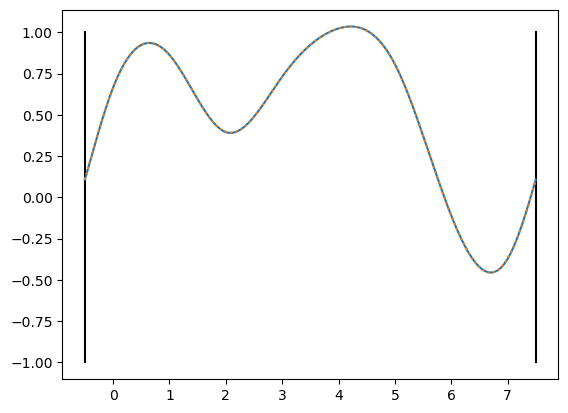

In [109]:
x1 = torch.linspace(-0.5, 7.5, 128)
x2 = torch.linspace(-0.5, 15.5, 128)
x4 = torch.linspace(-0.5, 8*32-0.5, 128)
plt.plot([-0.5, -0.5], [-1, 1], 'black')
plt.plot([7.5, 7.5], [-1, 1], 'black')
ax1 = plt.plot(x1, grid_pull(coeff, x1[:, None], 3, bound='dft', extrapolate=True))[0]
# ax2 = plt.plot(x1, grid_pull(coeff_up2, x2[:, None], 3, bound='dft', extrapolate=True), '--')[0]
ax3 = plt.plot(x1, grid_pull(coeff_up4, x4[:, None], 3, bound='dft', extrapolate=True), ':')[0]
# ax3 = plt.plot(x1, grid_pull(coeff2, x2[:, None], 3, bound='dft', extrapolate=True), ':')[0]
# plt.legend([ax1, ax2, ax3], ['original', 'continuous minimizer', 'discrete minimizer'])
plt.show()

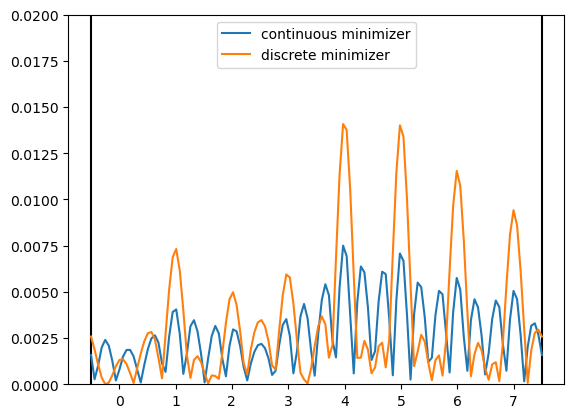

In [91]:
x1 = torch.linspace(-0.5, 7.5, 128)
x2 = torch.linspace(-0.5, 15.5, 128)
plt.plot([-0.5, -0.5], [-1, 1], 'black')
plt.plot([7.5, 7.5], [-1, 1], 'black')
ref =grid_pull(coeff, x1[:, None], 3, bound='dft', extrapolate=True)
ax2 = plt.plot(x1, (grid_pull(coeff_up, x2[:, None], 3, bound='dft', extrapolate=True) - ref).abs(), '-')[0]
ax3 = plt.plot(x1, (grid_pull(coeff2, x2[:, None], 3, bound='dft', extrapolate=True) - ref).abs(), '-')[0]
plt.legend([ax2, ax3], ['continuous minimizer', 'discrete minimizer'])
plt.ylim([0, 0.02])
plt.show()

In [89]:
print((grid_pull(coeff_up, x2[:, None], 3, bound='dft', extrapolate=True) - ref).abs().max())
print((grid_pull(coeff2, x2[:, None], 3, bound='dft', extrapolate=True) - ref).abs().max())

tensor(0.0075)
tensor(0.0141)
